# Exploratory Data Analysis
# ICD Codes: Patients Diagnoses

## MIMIC-IV dataset 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import statistics
from scipy import stats
import scipy.stats
from scipy.stats import norm
import plotly.express as px
import seaborn as sns

### ICD codes for Diagnoses

In [53]:
# icd_codes for diagnoses
icd_diag = pd.read_csv('d_icd_diagnoses.csv.gz', compression='gzip')

#### Variables

In [54]:
icd_diag

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
...,...,...,...
109770,Z992,10,Dependence on renal dialysis
109771,Z993,10,Dependence on wheelchair
109772,Z998,10,Dependence on other enabling machines and devices
109773,Z9981,10,Dependence on supplemental oxygen


In [55]:
icd_diag.icd_version.value_counts()

icd_version
10    95109
9     14666
Name: count, dtype: int64

### Patients Daignoses

In [56]:
# Patients diagnoses
diag_icd = pd.read_csv('diagnoses_icd.csv.gz', compression='gzip')

#### Variables

In [57]:
diag_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [58]:
diag_icd.subject_id.nunique()

180640

In [59]:
diag_icd.icd_code.nunique()

25809

In [60]:
print("There are", total_pat_,"patients listed in the hospital, but only",total_pat,"are listed as admitted by the services and only",diag_icd.subject_id.nunique(), "have a diagnostic registered.")

There are 299712 patients listed in the hospital, but only 180733 are listed as admitted by the services and only 180640 have a diagnostic registered.


In [61]:
diag_icd.groupby("subject_id").value_counts()

subject_id  hadm_id   seq_num  icd_code  icd_version
10000032    22595853  1        5723      9              1
                      2        78959     9              1
            29079034  13       5715      9              1
                      12       29680     9              1
                      11       496       9              1
                                                       ..
19999987    23865745  5        5990      9              1
                      3        20280     9              1
                      2        3485      9              1
                      1        431       9              1
                      11       7810      9              1
Name: count, Length: 4756326, dtype: int64

In [62]:
diag_icd.groupby("icd_version")["icd_code"].nunique()

icd_version
9      9072
10    16757
Name: icd_code, dtype: int64

#### Merge with icd_diagnoses

In [63]:
merge_diag = pd.merge(diag_icd,icd_diag,  on='icd_code', how='inner')
merge_diag.drop(columns = ['icd_version_y'], inplace=True)
merge_diag.rename(columns={'long_title': 'diagnose', 'icd_version_x': 'icd_version'}, inplace=True)
merge_diag.sort_values("subject_id").head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,diagnose
0,10000032,22595853,1,5723,9,Portal hypertension
93914,10000032,25742920,8,V08,9,Asymptomatic human immunodeficiency virus [HIV...
93915,10000032,29079034,8,V08,9,Asymptomatic human immunodeficiency virus [HIV...
96951,10000032,22841357,8,3051,9,Tobacco use disorder
96952,10000032,25742920,9,3051,9,Tobacco use disorder


In [64]:
merge_diag.subject_id.nunique()

180640

In [65]:
merge_diag.icd_code.nunique()

25809

In [66]:
merge_diag.icd_code.value_counts()

icd_code
4019       97361
2724       63875
I10        51706
E785       48581
53081      46238
           ...  
31223          1
37723          1
H462           1
C061           1
O359XX2        1
Name: count, Length: 25809, dtype: int64

##### Set all icd codes to icd10

In [67]:
#!pip install icd-mappings
from icdmappings import Mapper
#FROM IC10 TO CCSR
mapper = Mapper()
icd_codes_9 = merge_diag[merge_diag['icd_version'] == 9]['icd_code']
new_icd10_codes = mapper.map(icd_codes_9, source='icd9', target='icd10')
new_icd10_code= merge_diag.loc[merge_diag['icd_version'] == 9, 'icd_code']
merge_diag10=merge_diag
merge_diag10['icd10_code'] = new_icd10_code
merge_diag10 = merge_diag10.dropna() 

In [68]:
merge_diag10=merge_diag10.drop(columns=["icd_code","icd_version"])

In [69]:
merge_diag10

,subject_id,hadm_id,seq_num,diagnose,icd10_code
0,10000032,22595853,1,Portal hypertension,5723
1,10000826,20032235,4,Portal hypertension,5723
2,10000826,28289260,1,Portal hypertension,5723
3,10005866,26158160,4,Portal hypertension,5723
4,10008924,23676183,7,Portal hypertension,5723
...,...,...,...,...,...
4860264,19975121,28839110,3,Herpes zoster with unspecified complication,0538
4860266,19983257,21588174,17,"Emollients, demulcents, and protectants causin...",E9463
4860269,19985683,25819866,6,"Benign neoplasm of pharynx, unspecified",2109
4860271,19989305,29998115,2,Cor triatriatum,74682


In [70]:
merge_diag10["icd10_code"].nunique()

9072

These are the most prevalent diagonoses (IC10) at the hospital:


<Axes: title={'center': 'ICD10 diagnoses'}, ylabel='diagnose'>

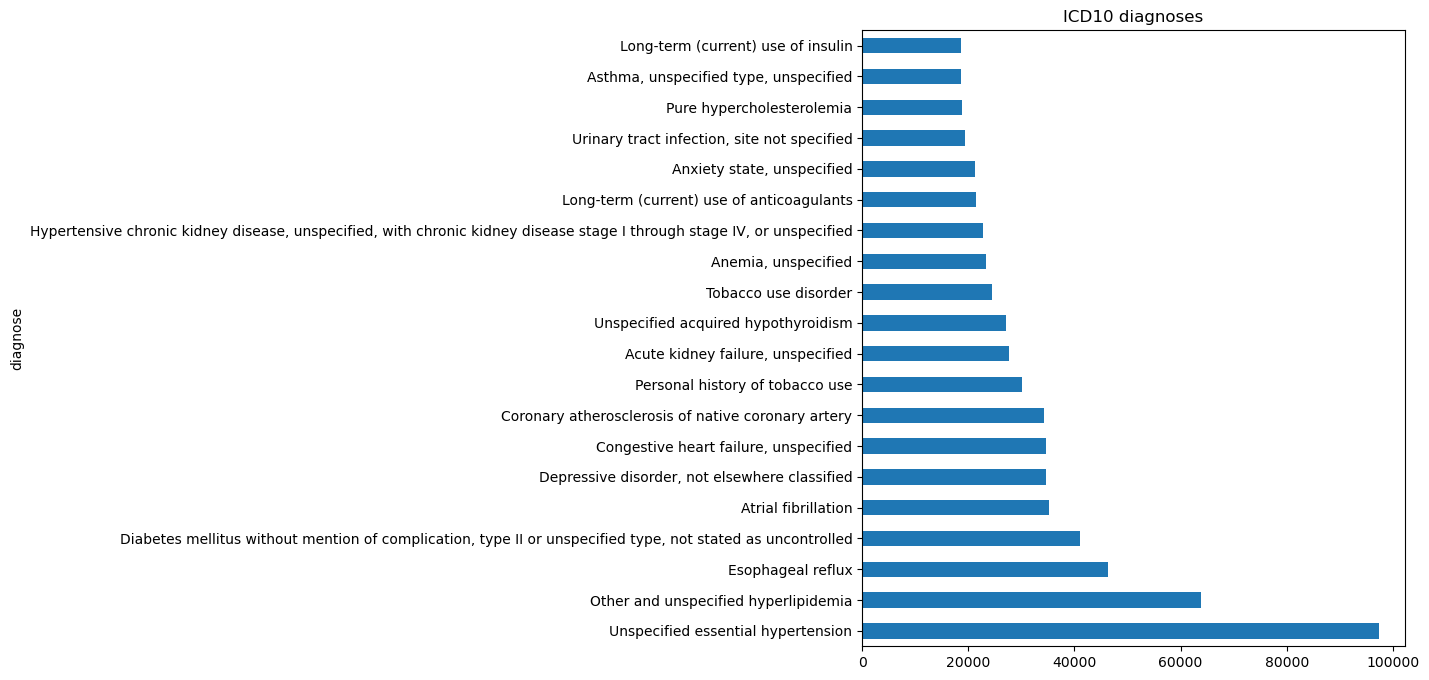

In [71]:
print("These are the most prevalent diagonoses (IC10) at the hospital:")

merge_diag10["diagnose"].value_counts().head(20).plot.barh(figsize=(7,8), title="ICD10 diagnoses")

##### Set all icd codes to CCSR

In [72]:
#!pip install icd-mappings
from icdmappings import Mapper
#FROM IC10 TO CCSR
mapper = Mapper()
icd_codes_version_9 = diag_icd[diag_icd['icd_version'] == 9]['icd_code']
new_icd10_codes = mapper.map(icd_codes_version_9, source='icd9', target='icd10')
new_icd10_code= diag_icd.loc[diag_icd['icd_version'] == 9, 'icd_code']

all_icd_10_codes = diag_icd['icd_code']
ccsr_codes = mapper.map(all_icd_10_codes, source='icd10', target='ccsr')

In [73]:
diag_ccsr=diag_icd
diag_ccsr['ccsr_code'] = ccsr_codes
diag_ccsr = diag_ccsr.dropna()

In [74]:
merge_diag = pd.merge(diag_ccsr,icd_diag,  on='icd_code', how='inner')
merge_diag.drop(columns = ['icd_version_y'], inplace=True)
merge_diag.rename(columns={'long_title': 'diagnose', 'icd_version_x': 'icd_version'}, inplace=True)
#merge_diag.sort_values("subject_id").head()

In [75]:
merge_diag#.sort_values("subject_id")

,subject_id,hadm_id,seq_num,icd_code,icd_version,ccsr_code,diagnose
0,10000084,23052089,1,G3183,10,NVS011,Dementia with Lewy bodies
1,10110584,24580984,5,G3183,10,NVS011,Dementia with Lewy bodies
2,10229302,26194242,14,G3183,10,NVS011,Dementia with Lewy bodies
3,10279514,29624303,13,G3183,10,NVS011,Dementia with Lewy bodies
4,10301059,27289844,3,G3183,10,NVS011,Dementia with Lewy bodies
...,...,...,...,...,...,...,...
2016211,19990427,29695607,24,T24011A,10,INJ019,"Burn of unspecified degree of right thigh, ini..."
2016212,19996016,28015466,4,O30093,10,PRG012,"Twin pregnancy, unable to determine number of ..."
2016213,19996783,25894657,20,H353131,10,EYE005,"Nonexudative age-related macular degeneration,..."
2016214,19997062,20096107,1,K8036,10,DIG017,Calculus of bile duct with acute and chronic c...


In [76]:
merge_diag.diagnose.nunique()

16756

These are the most prevalent diagonoses (CCSR) at the hospital:


<Axes: title={'center': 'Diagnose'}, ylabel='diagnose'>

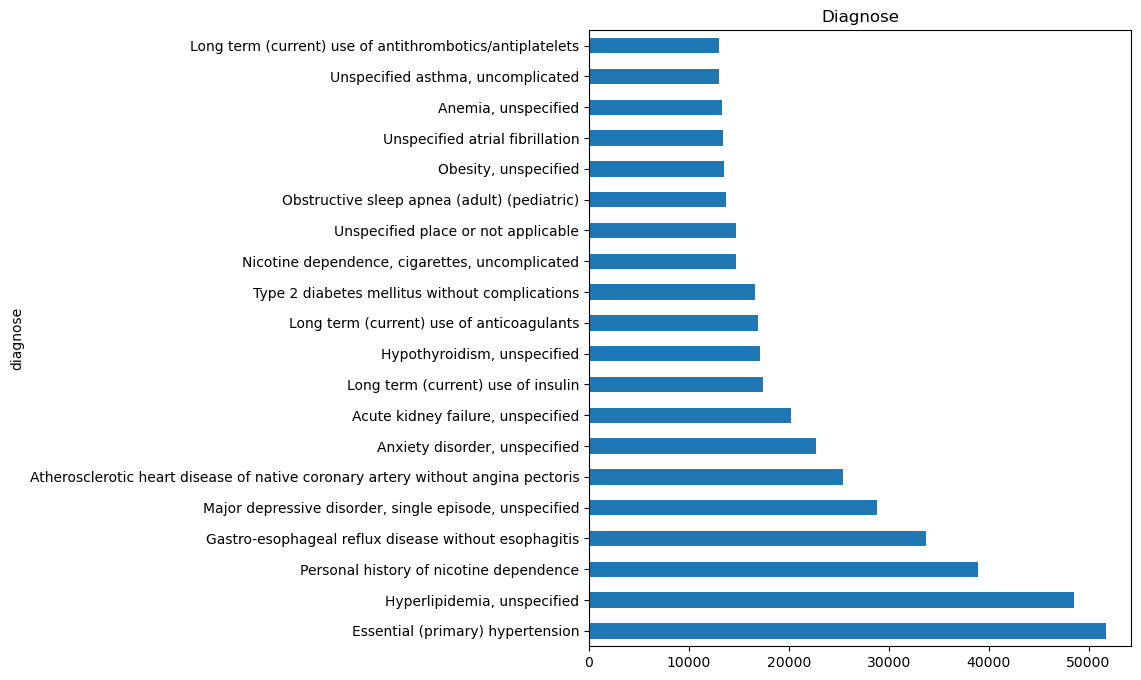

In [77]:
print("These are the most prevalent diagonoses (CCSR) at the hospital:")

merge_diag["diagnose"].value_counts().head(20).plot.barh(figsize=(7,8), title="Diagnose")

These are the most prevalent CCSR codes at the hospital:


<Axes: title={'center': 'CCSR code'}, ylabel='ccsr_code'>

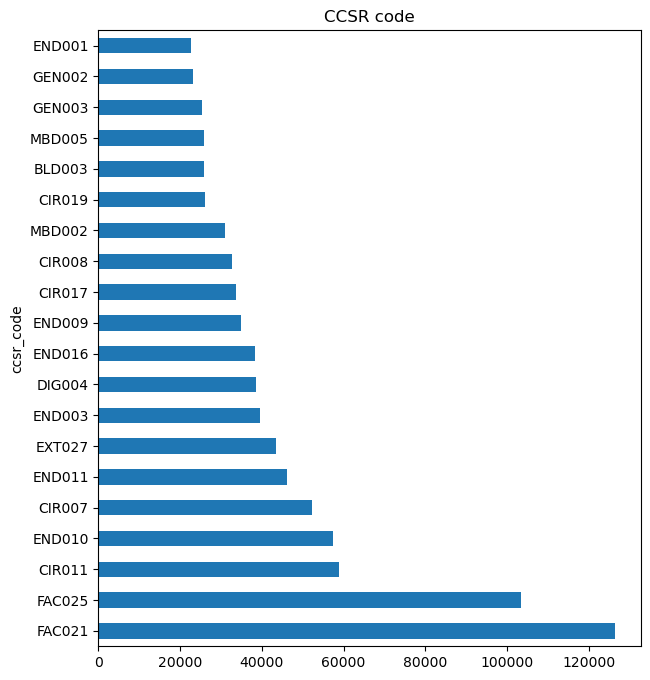

In [78]:
print("These are the most prevalent CCSR codes at the hospital:")

merge_diag["ccsr_code"].value_counts().head(20).plot.barh(figsize=(7,8), title="CCSR code")

#### CCSR Diagnoses Description

In [79]:
# ccsr_codes for diagnoses
# taken from https://github.com/HHS-AHRQ/MEPS/blob/master/Quick_Reference_Guides/meps_ccsr_conditions.csv 

ccsr_diag = pd.read_csv('meps_ccsr_conditions.csv')

In [80]:
ccsr_diag.head()

,CCSR Code,CCSR Description,MEPS collapsed condition category,Category Body System
0,BLD000,Diseases of the Blood and Blood Forming Organs...,Other disorders of blood and immune system,BLD: Diseases of the blood and blood-forming o...
1,BLD001,Nutritional anemia,Anemia,BLD: Diseases of the blood and blood-forming o...
2,BLD002,Hemolytic anemia,Anemia,BLD: Diseases of the blood and blood-forming o...
3,BLD003,Aplastic anemia,Anemia,BLD: Diseases of the blood and blood-forming o...
4,BLD004,Acute posthemorrhagic anemia,Other disorders of blood and immune system,BLD: Diseases of the blood and blood-forming o...


In [81]:
ccsr_diag.shape

(567, 4)

In [82]:
ccsr_diag.rename(columns={'CCSR Code': 'ccsr_code'},inplace=True)

In [83]:
ccsr_diag_merged = pd.merge(merge_diag,ccsr_diag,  on='ccsr_code', how='inner')
#merge_diag.drop(columns = ['icd_version_y'], inplace=True)
#merge_diag.rename(columns={'long_title': 'diagnose', 'icd_version_x': 'icd_version'}, inplace=True)

In [84]:
ccsr_diag_merged.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,ccsr_code,diagnose,CCSR Description,MEPS collapsed condition category,Category Body System
0,10000084,23052089,1,G3183,10,NVS011,Dementia with Lewy bodies,Neurocognitive disorders,Neurocognitive disorders (including dementia a...,NVS: Diseases of the nervous system
1,10110584,24580984,5,G3183,10,NVS011,Dementia with Lewy bodies,Neurocognitive disorders,Neurocognitive disorders (including dementia a...,NVS: Diseases of the nervous system
2,10229302,26194242,14,G3183,10,NVS011,Dementia with Lewy bodies,Neurocognitive disorders,Neurocognitive disorders (including dementia a...,NVS: Diseases of the nervous system
3,10279514,29624303,13,G3183,10,NVS011,Dementia with Lewy bodies,Neurocognitive disorders,Neurocognitive disorders (including dementia a...,NVS: Diseases of the nervous system
4,10301059,27289844,3,G3183,10,NVS011,Dementia with Lewy bodies,Neurocognitive disorders,Neurocognitive disorders (including dementia a...,NVS: Diseases of the nervous system


In [85]:
ccsr_diag_merged.shape

(2016216, 10)

In [86]:
ccsr_diag_merged.subject_id.nunique()

86611

These are the most prevalent CCSR diagnoses at the hospital:


<Axes: title={'center': 'CCSR Description'}, ylabel='CCSR Description'>

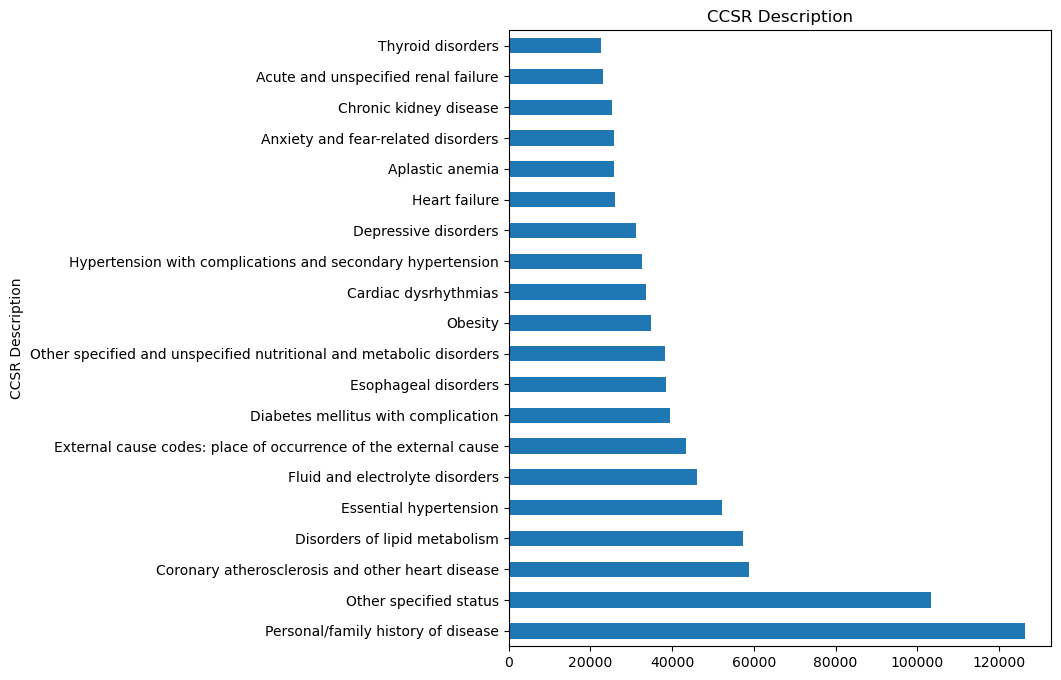

In [87]:
print("These are the most prevalent CCSR diagnoses at the hospital:")

ccsr_diag_merged["CCSR Description"].value_counts().head(20).plot.barh(figsize=(7,8), title="CCSR Description")

<Axes: title={'center': 'CCSR Category'}, ylabel='Category Body System'>

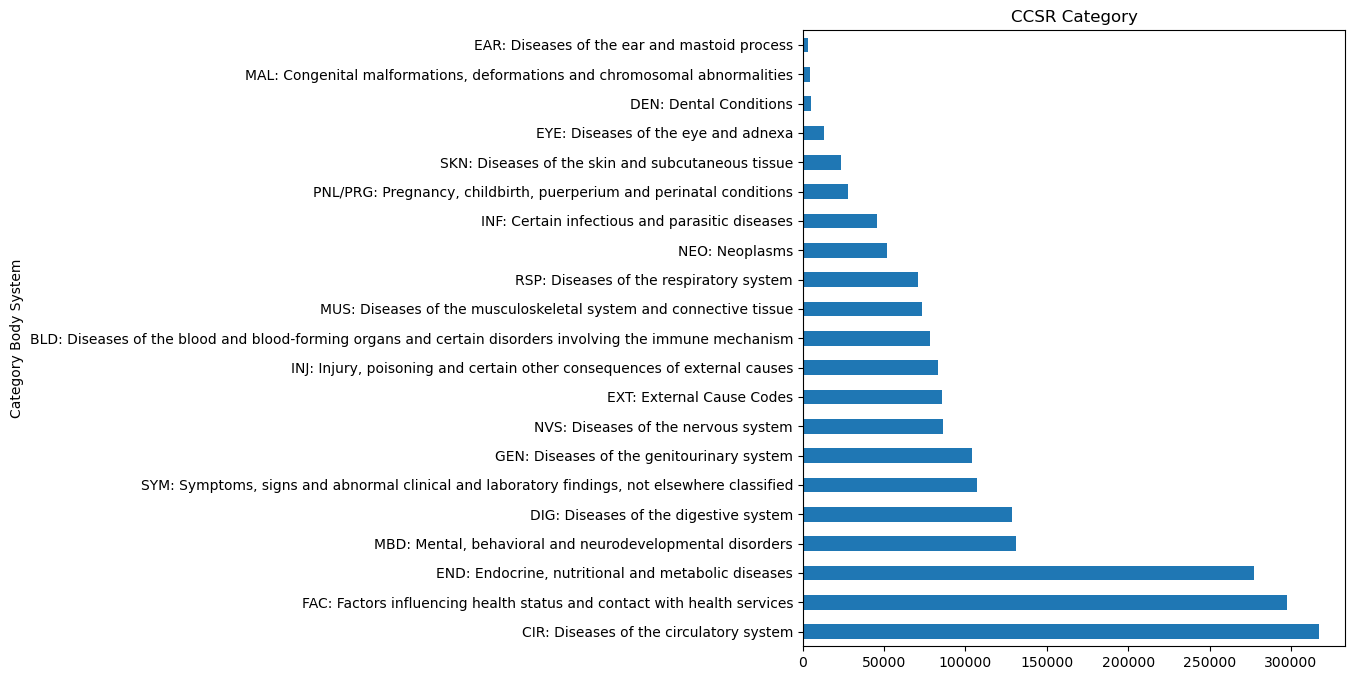

In [88]:
ccsr_diag_merged["Category Body System"].value_counts().plot.barh(figsize=(7,8), title="CCSR Category")

#### Save 'diagnoses_ccsr.csv' file

In [89]:
### Save this CSV file
ccsr_diag_merged.to_csv('diagnoses_ccsr.csv', index=False)